In [3]:
import numpy as np
import scipy as sp
from math import pi, tanh
from cmath import sqrt
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from ipywidgets import interact

In [7]:
# nu=1
D1_n1=0.4
D2_n1=0.3
k0=1.2

# nu=2
D1_n2=0.2
D1t=0.
D2_n2=0.4
k0u=2.2
k0d=1.


s0=np.array([[1,0],[0,1]])
sx=np.array([[0,1],[1,0]])
sy=np.array([[0,-1j],[1j,0]])
sz=np.array([[1,0],[0,-1]])
s_up=(sz+s0)/2
s_dn=(s0-sz)/2

def Reh_calc_nu1(Esw0,D1,D2):
    Ree=np.zeros(len(Esw0))
    Reh=np.zeros(len(Esw0))

    Ham=  -k0* np.kron(sz,s0) +D1*np.kron(sy,sy) #+ G* np.kron(sz,sx)
    vk= np.kron(s0,sz)+ D2*np.kron(sx,s0)
    Hd= np.linalg.inv(vk)

    for i_E in range(len(Esw0)):
        E=Esw0[i_E]
        Ht= np.dot(Hd,E*np.eye(4)-  Ham)
        evs, evecs = np.linalg.eig(Ht)

        i_evan= np.where( np.abs(np.imag(evs)) > 1e-5 )[0]
        ie_T= np.where( np.imag(evs[i_evan]) > 0)[0]
        ie_R= np.where( np.imag(evs[i_evan]) < 0)[0]

        i_prop= np.where( np.abs(np.imag(evs)) < 1e-5 )[0]
        evecs_inv=np.linalg.inv(evecs)
    #     evecs_inv=np.transpose(evecs)
        Jmat = np.reshape(np.diag(np.dot(evecs_inv,np.dot(vk,evecs))),[4,])
        ip_T= np.where( np.real(Jmat[i_prop]) > 0)[0]
        ip_R= np.where( np.real(Jmat[i_prop]) < 0)[0]

        i_T=np.concatenate((i_prop[ip_T],i_evan[ie_T]))
        i_R=np.concatenate((i_prop[ip_R],i_evan[ie_R]))

        evecs= np.dot(evecs,np.diag(1/Jmat**0.5))
        Tevecs = evecs[:,i_T]    
        Revecs = evecs[:,i_R]    
        evecs_0= np.concatenate((Tevecs,Revecs),axis=1)


        Revecs_l= np.array([[0,1,0,0],[0,0,0,1]]).T
        Tevecs_l= np.array([[1,0,0,0],[0,0,1,0]]).T
        evecs_l= np.concatenate((Tevecs_l,Revecs_l),axis=1)

        Tmat=sp.linalg.solve(evecs_0,evecs_l)
        Tz=[[1-1j*Z,0,-1j*Z,0],\
            [0,1+1j*Z,0,-1j*Z],\
            [1j*Z,0,1+1j*Z,0],\
            [0,1j*Z,0,1-1j*Z]]
        Tt=np.dot(Tmat,Tz)
        TLL=Tt[np.ix_([2,3],[2,3])]
        TLR=Tt[np.ix_([2,3],[0,1])]
    #     TRL=Tt[np.ix_([0,1],[2,3])]
        x= -sp.linalg.solve(TLL,TLR)
    #     x= -np.dot(np.linalg.inv(TLL),TLR)
        Ree[i_E] = np.abs(x[0,0])**2
        Reh[i_E] = np.abs(x[1,0])**2
    #     print(Ree[i_E],Reh[i_E])

    return Ree,Reh


def Reh_calc_nu2(Esw0, D1,D2):
    Ree0=np.zeros(len(Esw0))
    Reh0=np.zeros(len(Esw0))

    Ham=  - k0u* np.kron(sz,np.kron(s0,s_up))\
            - k0d* np.kron(sz,np.kron(s0,s_dn))\
            + D1*np.kron(sy,np.kron(sx,sy))\
            + D1t*np.kron(sy,np.kron(s0,sy))\
            + D2*np.kron(sy,np.kron(sy,s0))

    vk= np.kron(s0,np.kron(sz,s0))
    Hd= np.linalg.inv(vk)


    for i_E in range(len(Esw0)):
        E=Esw0[i_E]
        Ht= np.dot(Hd,E*np.eye(8)-  Ham)
        evs, evecs = np.linalg.eig(Ht)

        i_evan= np.where( np.abs(np.imag(evs)) > 1e-5 )[0]
        ie_T= np.where( np.imag(evs[i_evan]) > 0)[0]
        ie_R= np.where( np.imag(evs[i_evan]) < 0)[0]

        i_prop= np.where( np.abs(np.imag(evs)) < 1e-5 )[0]
        evecs_inv=np.linalg.inv(evecs)
    #     evecs_inv=np.transpose(evecs)
        Jmat = np.reshape(np.diag(np.dot(evecs_inv,np.dot(vk,evecs))),[8,])
        ip_T= np.where( np.real(Jmat[i_prop]) > 0)[0]
        ip_R= np.where( np.real(Jmat[i_prop]) < 0)[0]

        i_T=np.concatenate((i_prop[ip_T],i_evan[ie_T]))
        i_R=np.concatenate((i_prop[ip_R],i_evan[ie_R]))

        evecs= np.dot(evecs,np.diag(1/Jmat**0.5))
        Tevecs = evecs[:,i_T]    
        Revecs = evecs[:,i_R]    
        evecs_0= np.concatenate((Tevecs,Revecs),axis=1)


        Revecs_l= np.kron(np.array([[0,1,0,0],[0,0,0,1]]).T,s0)
        Tevecs_l= np.kron(np.array([[1,0,0,0],[0,0,1,0]]).T,s0)
        evecs_l= np.concatenate((Tevecs_l,Revecs_l),axis=1)

        Tmat=sp.linalg.solve(evecs_0,evecs_l)
        Tz=[[1-1j*Z,0,-1j*Z,0],\
            [0,1+1j*Z,0,-1j*Z],\
            [1j*Z,0,1+1j*Z,0],\
            [0,1j*Z,0,1-1j*Z]]
        Tt=np.dot(Tmat,np.kron(Tz,s0))
        TLL=Tt[np.ix_([4,5,6,7],[4,5,6,7])]
        TLR=Tt[np.ix_([4,5,6,7],[0,1,2,3])]
        x= -sp.linalg.solve(TLL,TLR)
    #     x= -np.dot(np.linalg.inv(TLL),TLR)
        Ree0[i_E] = np.sum(np.abs(x[0,0:2])**2+np.abs(x[1,0:2])**2)
        Reh0[i_E] = np.sum(np.abs(x[2,0:2])**2+np.abs(x[3,0:2])**2)
    #     print(Ree[i_E],Reh[i_E])

    return Ree0,Reh0


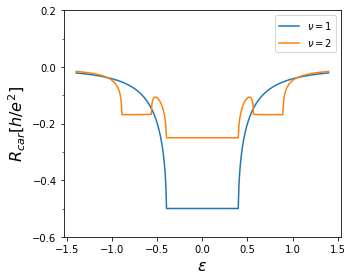

In [20]:
# T matrix with Z
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

Z=0.
Esw= np.linspace(-1.4,1.4,800)

fig, ax = plt.subplots(figsize=(5,4))

Ree1,Reh1= Reh_calc_nu1(Esw0=Esw,D1=D1_n1,D2=D2_n1)
# plt.plot(Esw,Reh1,label=r'$\nu=1$')
x1= Ree1- Reh1
plt.plot(Esw,x1/(1-x1),label=r'$\nu=1$')


Ree2,Reh2= Reh_calc_nu2(Esw0=Esw,D1=D1_n2,D2=D2_n2)
# plt.plot(Esw,Reh2,label=r'$\nu=2$')
x2= Ree2- Reh2
plt.plot(Esw,x2/(2-x2)/2,label=r'$\nu=2$')


ax.legend()
fsize=16
plt.ylabel(r"$R_{car} [h/e^2]$",fontsize = fsize)
plt.xlabel(r"$\varepsilon$",fontsize = fsize)
# plt.xticks(np.arange(-0.08,0.081,0.04))
plt.yticks(np.arange(-0.6,0.21,0.2))
# plt.legend(loc='upper right')

ax.yaxis.set_minor_locator(AutoMinorLocator(2))

plt.tight_layout()
plt.savefig('figs/CAR_eff_nu_comp_vs_E.pdf')
plt.show()